In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import numpy as np
import os.path as op
import torch.nn.functional as F
import argparse
import matplotlib.pyplot as plt
from PIL import Image

from datasets import build_dataloader
from utils.checkpoint import Checkpointer
from model import build_model
from utils.metrics import Evaluator
from utils.iotools import load_train_configs
from utils.logger import setup_logger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 画图函数：展示 ground truth 图像及检索得到的图像
def plot_retrieval_images(query_id, image_ids, query_caption, 
                          image_paths, gt_img_path, 
                          fname=None, fname_t=None):
    print("Query image id:", query_id)
    print("Query caption:", query_caption)
    print("Retrieved image ids:", image_ids)

    # 1. 绘制 Ground Truth 图像
    fig_gt = plt.figure()
    img = Image.open(gt_img_path)
    img = img.resize((128, 256))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if fname_t:
        plt.savefig(fname_t, dpi=300, bbox_inches='tight', format='svg')
    fig_gt.show()
    plt.close(fig_gt)
    
    # 2. 绘制检索到的图像
    fig_ret = plt.figure()
    col = len(image_paths)
    for i in range(col):
        plt.subplot(1, col, i+1)
        img = Image.open(image_paths[i])
        ax = plt.gca()
        # 如果检索得到的图像 id 与查询图像 id 相同，用绿色边框，否则红色
        if image_ids[i] == query_id:
            color = 'lawngreen'
        else:
            color = 'red'
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_color(color)
        img = img.resize((128, 256))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    fig_ret.show()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight', format='svg')
#     plt.close(fig_ret)

# -------------------------------
# 基于图像 id 获取文本→图像检索结果
def get_text_to_image_result(image_idx, qfeats, gfeats, qids, gids, captions, img_paths, gt_img_paths):
    gids_list = gids.cpu().tolist() if torch.is_tensor(gids) else gids
    qids_list = qids.cpu().tolist() if torch.is_tensor(qids) else qids
    
    # 从图像侧获取查询图像 id 和对应的路径（ground truth）
    query_img_id = gids_list[image_idx]
    gt_img_path = gt_img_paths[image_idx]
    # 从文本侧找到与该图像 id 对应的所有文本（可能有多个）
    matching_text_indices = [i for i, qid in enumerate(qids_list) if qid == query_img_id]
    if not matching_text_indices:
        raise ValueError(f"No text found for image id {query_img_id}")
    
    # 取第一个作为查询文本
    chosen_text_idx = matching_text_indices[0]
    query_caption = captions[chosen_text_idx]
    
    # 基于选定的文本计算文本→图像相似度
    similarity_t2i = qfeats[chosen_text_idx] @ gfeats.t()  # 得到各图像相似度
    _, indices_t2i = torch.topk(similarity_t2i, k=10, largest=True, sorted=True)
    indices_t2i = indices_t2i.tolist()
    retrieved_image_ids = [gids_list[j] for j in indices_t2i]
    retrieved_image_paths = [img_paths[j] for j in indices_t2i]
    
    return query_img_id, query_caption, retrieved_image_ids, retrieved_image_paths, gt_img_path

# -------------------------------
# 基于图像 id 获取图像→文本检索结果
def get_image_to_text_result(image_idx, qfeats, gfeats, qids, gids, captions, img_paths):
    gids_list = gids.cpu().tolist() if torch.is_tensor(gids) else gids
    qids_list = qids.cpu().tolist() if torch.is_tensor(qids) else qids
    query_img_id = gids_list[image_idx]
    query_img_path = img_paths[image_idx]
    
    similarity_i2t = gfeats[image_idx] @ qfeats.t()  
    _, indices_i2t = torch.topk(similarity_i2t, k=10, largest=True, sorted=True)
    indices_i2t = indices_i2t.tolist()
    retrieved_texts = [captions[i] for i in indices_i2t]
    
    gt_texts = [captions[i] for i, qid in enumerate(qids_list) if qid == query_img_id]
    
    return query_img_path, gt_texts, retrieved_texts

D:\Anaconda3\envs\Image-Text\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-21 22:59:21,666 McRSA INFO: {'MLM': True, 'alpha': 0.9, 'batch_size': 32, 'beta': 0.999, 'bias_lr_factor': 2.0, 'cmt_depth': 4, 'dataset_name': 'MSCOCO', 'distributed': False, 'eval_period': 1, 'gamma': 0.1, 'id_loss_weight': 1.0, 'img_aug': False, 'img_size': (384, 128), 'local_rank': 0, 'log_period': 300, 'loss_names': 'ppe+mcu+fsa', 'lr': 1e-05, 'lr_factor': 5.0, 'lrscheduler': 'cosine', 'masked_token_rate': 0.8, 'masked_token_unchanged_rate': 0.1, 'milestones': (20, 50), 'mlm_loss_weight': 1.0, 'momentum': 0.9, 'name': 'baseline', 'num_epoch': 60, 'num_instance': 4, 'num_workers': 8, 'optimizer': 'Adam', 'output_dir': 'F:\\result_TMM\\Visualization\\MSCOCO\\McRSA/', 'power': 0.9, 'pretrain_choice': 'ViT-B/16', 'resume': False, 'resume_ckpt_file': '', 'root_dir': 'F:\\DataSet\\CrossModalRetrieval\\Image_Text', 'sampler': 'random', 'stride_size': 16, 'target_lr': 0, 'temperature': 0.02, 'test_batch_size': 4, 'text_length': 77, 'training': False, 'val_dataset': 'test', 'vocab_

D:\Anaconda3\envs\Image-Text\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


2025-02-21 23:01:00,441 McRSA.eval INFO: Average time per iteration: 0.0071 s / it
2025-02-21 23:01:01,225 McRSA.dataset INFO: => MSCOCO Images and Captions are loaded
2025-02-21 23:01:01,226 McRSA.dataset INFO: MSCOCO Dataset statistics:
2025-02-21 23:01:01,227 McRSA.dataset INFO: 
+--------+--------+--------+----------+
| subset |  ids   | images | captions |
+--------+--------+--------+----------+
| train  | 113287 | 113287 |  566745  |
|  test  |  5000  |  5000  |  25008   |
|  val   |  5000  |  5000  |  25014   |
+--------+--------+--------+----------+
Query image id: 0
Query caption: three tennis players on a court playing tennis
Retrieved image ids: [0, 3880, 4258, 2442, 814, 1249, 3956, 2439, 3230, 3157]


C:\Users\user\AppData\Local\Temp\ipykernel_25084\3101757830.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_gt.show()
C:\Users\user\AppData\Local\Temp\ipykernel_25084\3101757830.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ret.show()


Query image id: 10
Query caption: A ocean filled with many different white boats.
Retrieved image ids: [10, 4559, 1566, 3631, 456, 1696, 4756, 1948, 4608, 4494]
Query image id: 20
Query caption: a young boy putting stuff in a little train marked "daddy"
Retrieved image ids: [20, 473, 4116, 1328, 785, 6, 4329, 521, 692, 4752]
Query image id: 30
Query caption: A guy stands beside several detailed, artsy vases in China.
Retrieved image ids: [30, 1895, 2080, 437, 26, 1973, 1316, 183, 1256, 1810]
Query image id: 40
Query caption: a vase of purple flowers in the sunlight
Retrieved image ids: [40, 2795, 1540, 669, 677, 3671, 4698, 3331, 3917, 3217]
Query image id: 50
Query caption: A cow is standing in the grass near a fence.
Retrieved image ids: [367, 3310, 50, 2899, 868, 2300, 4003, 727, 4236, 2799]
Query image id: 60
Query caption: A metal stove and a counter in a room.
Retrieved image ids: [1154, 60, 4645, 2748, 3411, 2016, 2537, 2033, 1411, 3261]
Query image id: 70
Query caption: Snowboa

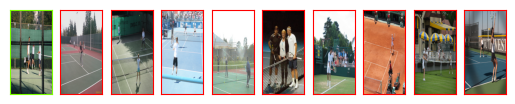

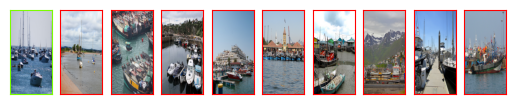

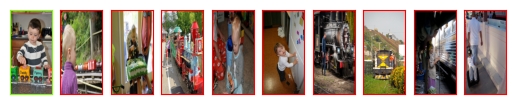

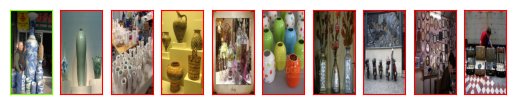

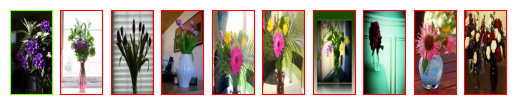

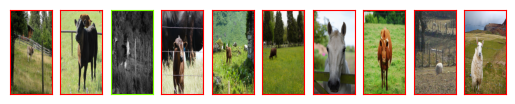

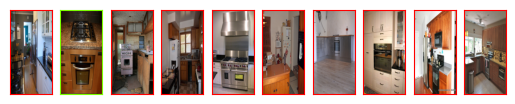

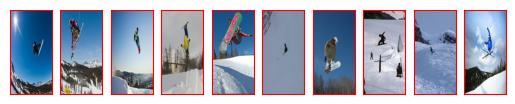

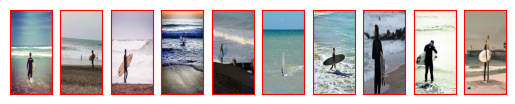

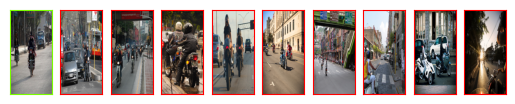

In [2]:
# -------------------------------
# 主程序：加载模型、数据及进行检索
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description="McRSA Test")
    dataset_dir = r'F:\DataSet\CrossModalRetrieval\Image_Text'
    root_dir = r'F:\result_TMM\Visualization'

    pretrain_set = 'MSCOCO'  # 可选: CUHK-PEDES, RSTPReid, Flickr_30k, MSCOCO, ICFG-PEDES
    premodel = os.path.join(root_dir, pretrain_set)
    Method = 'McRSA'  # 可选：IRRA, McRSA

    McRSRLib = {'RSTPReid': '58.65_bs256_37056_2',
                'CUHK-PEDES': '69.12_bs32_37056_2',
                'ICFG-PEDES': '',
                'MSCOCO': '',
                'Flickr_30k': '61.98_bs128_37056_2'}
    weightLib = {'IRRA': '68.78irra_30756',
                 'McRSA': McRSRLib[pretrain_set]}
    Pretrain_Lib = {pretrain_set: weightLib[Method]}

    weigt_fileName = Pretrain_Lib[pretrain_set]
    test_path = os.path.join(premodel, Method + '/' + weigt_fileName)
    path_test = os.path.join(premodel, test_path, 'configs.yaml')
    parser.add_argument("--config_file", default=path_test)
    args = parser.parse_args(args=[])
    args = load_train_configs(args.config_file)
    args.dataset_name = pretrain_set
    args.root_dir = dataset_dir
    args.output_dir = os.path.join(root_dir, test_path)
    args.training = False

    logger = setup_logger('McRSA', save_dir=args.output_dir, if_train=args.training)
    logger.info(args)

    # 构建数据加载器、模型、加载权重
    test_img_loader, test_txt_loader, num_classes = build_dataloader(args)
    model = build_model(args, num_classes=num_classes)
    checkpointer = Checkpointer(model)
    checkpointer.load(f=op.join(args.output_dir, 'best.pth'))
    model.to(device)
    evaluator = Evaluator(test_img_loader, test_txt_loader)

    # 计算文本和图像的 embedding
    qfeats, gfeats, qids, gids = evaluator._compute_embedding(model.eval())
    qfeats = F.normalize(qfeats, p=2, dim=1)  # 文本特征
    gfeats = F.normalize(gfeats, p=2, dim=1)  # 图像特征

    # -------------------------------
    # 加载数据集中图片路径与文本描述
    from datasets.cuhkpedes import CUHKPEDES
    from datasets.icfgpedes import ICFGPEDES
    from datasets.mscoco import MSCOCO
    from datasets.flickr_30k import Flickr_30k
    from datasets.rstpreid import RSTPReid

    factory = {'CUHK-PEDES': CUHKPEDES,
               'RSTPReid': RSTPReid,
               'Flickr_30k': Flickr_30k,
               'ICFG-PEDES': ICFGPEDES,
               'MSCOCO': MSCOCO}

    dataset = factory[pretrain_set](root=dataset_dir)
    test_dataset = dataset.test

    img_paths = test_dataset['img_paths']
    captions = test_dataset['captions']
    gt_img_paths = test_dataset['img_paths']  # 假设图像测试时路径与加载器一致

    # -------------------------------
    # 为保证双向检索结果来自同一真实样本，
    # 统一使用图像数据的索引作为查询入口
    FilePath = os.path.join(r'./results', Method, pretrain_set)
    if not os.path.exists(FilePath):
        os.makedirs(FilePath)

    num_samples = min(100, len(gids))
    for image_idx in range(0, num_samples, 10):
        # 1. 基于文本查询图像：
        # 从图像侧取样，根据图像 id 在文本侧寻找对应的文本（取第一个）
        query_img_id, query_caption, retrieved_image_ids, retrieved_image_paths, gt_img_path = \
            get_text_to_image_result(image_idx, qfeats, gfeats, qids, gids, captions, img_paths, gt_img_paths)
        
#         save_path_img = os.path.join(FilePath, f"{pretrain_set}_t2i_{image_idx}.svg")
#         save_path_img_t = os.path.join(FilePath, f"{pretrain_set}_t2i_{image_idx}_true.svg")
        save_path_img = os.path.join(FilePath, f"{pretrain_set}_{image_idx}.svg")
        save_path_img_t = os.path.join(FilePath, f"{pretrain_set}_{image_idx}_true.svg")
        plot_retrieval_images(query_img_id, retrieved_image_ids, 
                              query_caption, retrieved_image_paths, 
                              gt_img_path, fname=save_path_img,
                              fname_t=save_path_img_t)

        # 2. 基于图像查询文本：
        query_img_path, gt_texts, retrieved_texts = \
            get_image_to_text_result(image_idx, qfeats, gfeats, qids, gids, captions, img_paths)
        
#         save_path_txt = os.path.join(FilePath, f"{pretrain_set}_i2t_{image_idx}.txt")
        save_path_txt = os.path.join(FilePath, f"{pretrain_set}_{image_idx}.txt")
        with open(save_path_txt, 'w', encoding='utf-8') as f:
            f.write(f"Query Image Path: {query_img_path}\n")
            f.write("Ground Truth Texts:\n")
            for gt_text in gt_texts:
                f.write(f"- {gt_text}\n")
            f.write("\nRetrieved Texts:\n")
            for i, cap in enumerate(retrieved_texts):
                match_symbol = "✅" if cap in gt_texts else "❌"
                f.write(f"{i+1}. {cap} {match_symbol}\n")


C:\Users\user\AppData\Local\Temp\ipykernel_25084\3207812659.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


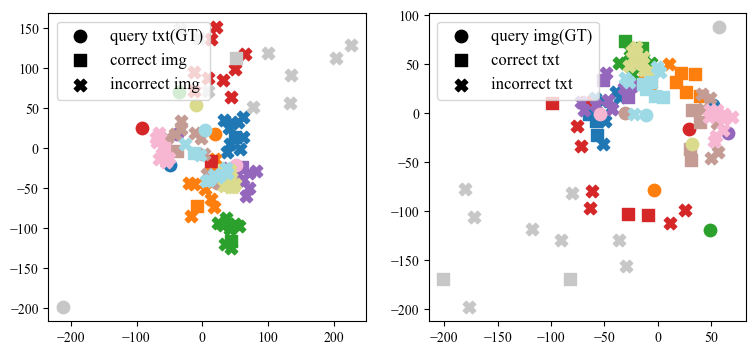

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.manifold import TSNE
plt.rcParams["font.family"] = "Times New Roman"

def generate_colors(num_classes):
    colors = plt.cm.get_cmap('tab20', num_classes)
    return [colors(i) for i in range(num_classes)]

def select_query_samples(gids, num_classes=5):
    unique_classes = list(set(gids.cpu().tolist()))
    selected_classes = random.sample(unique_classes, num_classes) 
    query_indices = [gids.cpu().tolist().index(cls) for cls in selected_classes] 
    return query_indices, selected_classes

# 可视化特征
def visualize_features(query_indices, qfeats, gfeats, qids, gids, num_classes):
    gids_list = gids.cpu().tolist()
    qids_list = qids.cpu().tolist()

    colors = generate_colors(num_classes)
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))  # 左：T→I，右：I→T

    # 全局图例
    shape_legend = {
        'query_img': 'query img(GT)',
        'query_txt': 'query txt(GT)',
        'retrieved_img_correct': 'correct img',
        'retrieved_img_incorrect': 'incorrect img',
        'retrieved_txt_correct': 'correct txt',
        'retrieved_txt_incorrect': 'incorrect txt',
    }
    
    for i, query_idx in enumerate(query_indices):
        color = colors[i] 
        matching_text_indices = [j for j, qid in enumerate(qids_list) if qid == gids_list[query_idx]]
        if not matching_text_indices:
            continue
        chosen_text_idx = matching_text_indices[0]
        similarity_t2i = qfeats[chosen_text_idx] @ gfeats.t()
        _, indices_t2i = torch.topk(similarity_t2i, k=10, largest=True, sorted=True)

        similarity_i2t = gfeats[query_idx] @ qfeats.t()
        _, indices_i2t = torch.topk(similarity_i2t, k=10, largest=True, sorted=True)

        retrieved_img_feats = gfeats[indices_t2i].cpu().numpy()
        retrieved_txt_feats = qfeats[indices_i2t].cpu().numpy()

        query_img_feat = gfeats[query_idx].cpu().numpy().reshape(1, -1)
        query_txt_feat = qfeats[chosen_text_idx].cpu().numpy().reshape(1, -1)

        all_feats = np.vstack((query_img_feat, query_txt_feat, retrieved_img_feats, retrieved_txt_feats))

        # t-SNE 降维
        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        embedded_feats = tsne.fit_transform(all_feats)
        
        S=80
        #左：T → I
        axes[0].scatter(embedded_feats[1, 0], embedded_feats[1, 1], color=color, marker='o', s=S)  # Query Text

        for j, idx in enumerate(indices_t2i):
            retrieved_gid = gids_list[idx] 
            correct = retrieved_gid == gids_list[query_idx]
            marker = 's' if correct else 'X' 
            axes[0].scatter(embedded_feats[2 + j, 0], embedded_feats[2 + j, 1], color=color, marker=marker, s=S)

        # 右：I → T
        axes[1].scatter(embedded_feats[0, 0], embedded_feats[0, 1], color=color, marker='o', s=S)  # Query Image

        for j, idx in enumerate(indices_i2t):
            retrieved_qid = qids_list[idx]  
            correct = retrieved_qid == qids_list[chosen_text_idx]
            marker = 's' if correct else 'X' 
            axes[1].scatter(embedded_feats[12 + j, 0], embedded_feats[12 + j, 1], color=color, marker=marker, s=S)

    #左图例（T→I）
    axes[0].scatter([], [], color='black', marker='o', s=S, label=shape_legend['query_txt'])
    axes[0].scatter([], [], color='black', marker='s', s=S, label=shape_legend['retrieved_img_correct'])
    axes[0].scatter([], [], color='black', marker='X', s=S, label=shape_legend['retrieved_img_incorrect'])

    #右图例（I→T）
    axes[1].scatter([], [], color='black', marker='o', s=S, label=shape_legend['query_img'])
    axes[1].scatter([], [], color='black', marker='s', s=S, label=shape_legend['retrieved_txt_correct'])
    axes[1].scatter([], [], color='black', marker='X', s=S, label=shape_legend['retrieved_txt_incorrect'])

    # 图例
    axes[0].legend(loc='upper left', fontsize=12)
    axes[1].legend(loc='upper left', fontsize=12)

#     axes[0].set_title("t2i")
#     axes[1].set_title("i2t")
    
#     plt.xticks(fontproperties='Times New Roman', size=20)
#     plt.yticks(fontproperties='Times New Roman', size=20) 
    
    plt.savefig(r'./results/clusters' + '/'+ pretrain_set +'.svg', format='svg', bbox_inches='tight')
    plt.show()


    
from sklearn.preprocessing import StandardScaler

qfeats_cpu = qfeats.cpu().numpy()
gfeats_cpu = gfeats.cpu().numpy()

scaler = StandardScaler()
qfeats_normalized = scaler.fit_transform(qfeats_cpu)
gfeats_normalized = scaler.transform(gfeats_cpu)  

qfeats_normalized = torch.tensor(qfeats_normalized).to(qfeats.device)
gfeats_normalized = torch.tensor(gfeats_normalized).to(gfeats.device)


num_classes = 10 
query_indices, selected_classes = select_query_samples(gids, num_classes=num_classes)
visualize_features(query_indices, qfeats_normalized, gfeats_normalized, qids, gids, num_classes)